In [1]:
import pandas as pd
df = pd.read_parquet(r"HELSINKI_ESPOO_CAR_PT_CO2_EmissionData_2023_H3_R9.parquet")
loc_df = pd.read_csv("Locomizer_latest_april_03.csv", usecols=["ORIGIN_CODE9", "ORIGIN_Municipality"])

# 2. Make sure the keys are both string type (for safe matching)
df["Origin_Hexagon_ID"] = df["Origin_Hexagon_ID"].astype(str)
loc_df["ORIGIN_CODE9"] = loc_df["ORIGIN_CODE9"].astype(str)

# 3. Drop duplicate ORIGIN_CODE9 if necessary (so each hex id has just one municipality)
loc_df = loc_df.drop_duplicates(subset=["ORIGIN_CODE9"])

# 4. Merge to add municipality
df = df.merge(
    loc_df.rename(columns={"ORIGIN_CODE9": "Origin_Hexagon_ID", "ORIGIN_Municipality": "origin_municipality"}),
    on="Origin_Hexagon_ID",
    how="left"  # Keeps all original rows, puts NaN if not found
)

# 5. (Optional) Save or preview result
print(df.head())

  Origin_Hexagon_ID Destination_Hexagon_ID  car_dist  car_time  car_co2  \
0   891126d2167ffff        891126d3073ffff  12103.72     40.99  1881.40   
1   891126d2167ffff        891126c2683ffff  13374.07     28.89  2078.87   
2   891126d2167ffff        8908996a98bffff  18903.82     36.22  2938.41   
3   891126d2167ffff        8908996d6b3ffff   9870.12     22.47  1534.21   
4   891126d2167ffff        89089961c6fffff  23900.66     43.11  3715.12   

   pt_dist  pt_time   pt_co2                             od_pair  \
0    16021     38.8   526.03  [891126d2167ffff, 891126d3073ffff]   
1    13765     36.4   761.13  [891126c2683ffff, 891126d2167ffff]   
2    21274     69.6   933.15  [8908996a98bffff, 891126d2167ffff]   
3     9027     35.1   340.53  [8908996d6b3ffff, 891126d2167ffff]   
4    27348     85.8  1476.23  [89089961c6fffff, 891126d2167ffff]   

   shortest_distance_x  shortest_distance_y origin_municipality  
0                  NaN                  NaN            Helsinki  
1       

In [2]:
# Load CSV with shortest distances
distances = pd.read_csv('hex_od_shortest_distances_all.csv')

# Again, create undirected OD key
def make_od_key(a, b):
    return tuple(sorted([a, b]))

# Create key columns for both DataFrames
df['od_pair'] = df.apply(lambda row: make_od_key(row['Origin_Hexagon_ID'], row['Destination_Hexagon_ID']), axis=1)
distances['od_pair'] = distances.apply(lambda row: make_od_key(row['origin_hex'], row['destination_hex']), axis=1)

# Merge shortest_distance into parquet DataFrame
merged = df.merge(distances[['od_pair', 'shortest_distance_m']], on='od_pair', how='left')

# Save result if you want


# Show sample
print(merged.head(4))

  Origin_Hexagon_ID Destination_Hexagon_ID  car_dist  car_time  car_co2  \
0   891126d2167ffff        891126d3073ffff  12103.72     40.99  1881.40   
1   891126d2167ffff        891126c2683ffff  13374.07     28.89  2078.87   
2   891126d2167ffff        8908996a98bffff  18903.82     36.22  2938.41   
3   891126d2167ffff        8908996d6b3ffff   9870.12     22.47  1534.21   

   pt_dist  pt_time  pt_co2                             od_pair  \
0    16021     38.8  526.03  (891126d2167ffff, 891126d3073ffff)   
1    13765     36.4  761.13  (891126c2683ffff, 891126d2167ffff)   
2    21274     69.6  933.15  (8908996a98bffff, 891126d2167ffff)   
3     9027     35.1  340.53  (8908996d6b3ffff, 891126d2167ffff)   

   shortest_distance_x  shortest_distance_y origin_municipality  \
0                  NaN                  NaN            Helsinki   
1                  NaN                  NaN            Helsinki   
2                  NaN                  NaN            Helsinki   
3                  N

In [3]:
import pandas as pd

# Load all attribute CSVs
df_pop = pd.read_csv("hex_population.csv")                 # columns: ID, population
df_speed = pd.read_csv("hexes_speed_traffic.csv")          # columns: ID, avg_speed, n_traffic_signals
df_area = pd.read_csv("hex_total_built_area.csv")          # columns: ID, total_built_area
df_stops = pd.read_csv("hexes_with_stop_counts.csv")    # columns: hex_id, stop_count

# Consistent column name for joining
df_pop = df_pop.rename(columns={'ID': 'hex_id'})
df_speed = df_speed.rename(columns={'ID': 'hex_id'})
df_area = df_area.rename(columns={'ID': 'hex_id'})

# Merge all dataframes on hex_id (outer join to keep all hexes)
df_merged = df_pop.merge(df_speed, on='hex_id', how='outer') \
                  .merge(df_area, on='hex_id', how='outer') \
                  .merge(df_stops, on='hex_id', how='outer')

print("Combined hex attribute table preview:")
print(df_merged.head())

# Save to CSV if you want
df_merged.to_csv("hex_attributes_combined.csv", index=False)
print("Saved as hex_attributes_combined.csv")


Combined hex attribute table preview:
            hex_id  population  avg_speed  n_traffic_signals  \
0  89089961003ffff           0        NaN                  0   
1  89089961007ffff           0        NaN                  0   
2  8908996100bffff           0        NaN                  0   
3  8908996100fffff           0        NaN                  0   
4  89089961013ffff           2        NaN                  0   

   total_built_area  stop_count  
0               0.0           0  
1               0.0           0  
2               0.0           0  
3               0.0           0  
4               0.0           0  
Saved as hex_attributes_combined.csv


In [4]:
import pandas as pd

# Load all attribute CSVs
df_pop = pd.read_csv("hex_population.csv")                 # columns: ID, population
df_speed = pd.read_csv("hexes_speed_traffic.csv")          # columns: ID, avg_speed, n_traffic_signals
df_area = pd.read_csv("hex_total_built_area.csv")          # columns: ID, total_built_area
df_stops = pd.read_csv("hexes_with_stop_counts.csv")    # columns: hex_id, stop_count

# Consistent column name for joining
df_pop = df_pop.rename(columns={'ID': 'hex_id'})
df_speed = df_speed.rename(columns={'ID': 'hex_id'})
df_area = df_area.rename(columns={'ID': 'hex_id'})

# Show unique hex counts
print(f"Population table hexes:      {df_pop['hex_id'].nunique()}")
print(f"Speed/traffic table hexes:   {df_speed['hex_id'].nunique()}")
print(f"Built area table hexes:      {df_area['hex_id'].nunique()}")
print(f"Stops table hexes:           {df_stops['hex_id'].nunique()}")

# Show how many are shared (intersection) between all tables
hexes_all = set(df_pop['hex_id']) & set(df_speed['hex_id']) & set(df_area['hex_id']) & set(df_stops['hex_id'])
print(f"Hexes present in all tables: {len(hexes_all)}")


Population table hexes:      8540
Speed/traffic table hexes:   8540
Built area table hexes:      8540
Stops table hexes:           8540
Hexes present in all tables: 8540


In [5]:
df_merged.head()

,hex_id,population,avg_speed,n_traffic_signals,total_built_area,stop_count
0,89089961003ffff,0,NaN,0,0.0,0
1,89089961007ffff,0,NaN,0,0.0,0
2,8908996100bffff,0,NaN,0,0.0,0
3,8908996100fffff,0,NaN,0,0.0,0
4,89089961013ffff,2,NaN,0,0.0,0


In [6]:
import pandas as pd

# Load combined attributes
attr = pd.read_csv("hex_attributes_combined.csv")

# Merge: attach attributes for origin hexagon
df_merged = merged.merge(attr, left_on='Origin_Hexagon_ID', right_on='hex_id', how='left', suffixes=('', '_origin'))

print(df_merged.head())
print(f"Resulting rows: {len(df_merged)}")


  Origin_Hexagon_ID Destination_Hexagon_ID  car_dist  car_time  car_co2  \
0   891126d2167ffff        891126d3073ffff  12103.72     40.99  1881.40   
1   891126d2167ffff        891126c2683ffff  13374.07     28.89  2078.87   
2   891126d2167ffff        8908996a98bffff  18903.82     36.22  2938.41   
3   891126d2167ffff        8908996d6b3ffff   9870.12     22.47  1534.21   
4   891126d2167ffff        89089961c6fffff  23900.66     43.11  3715.12   

   pt_dist  pt_time   pt_co2                             od_pair  \
0    16021     38.8   526.03  (891126d2167ffff, 891126d3073ffff)   
1    13765     36.4   761.13  (891126c2683ffff, 891126d2167ffff)   
2    21274     69.6   933.15  (8908996a98bffff, 891126d2167ffff)   
3     9027     35.1   340.53  (8908996d6b3ffff, 891126d2167ffff)   
4    27348     85.8  1476.23  (89089961c6fffff, 891126d2167ffff)   

   shortest_distance_x  shortest_distance_y origin_municipality  \
0                  NaN                  NaN            Helsinki   
1     

In [7]:
df=df_merged
df

,Origin_Hexagon_ID,Destination_Hexagon_ID,car_dist,car_time,car_co2,pt_dist,pt_time,pt_co2,od_pair,shortest_distance_x,shortest_distance_y,origin_municipality,shortest_distance_m,hex_id,population,avg_speed,n_traffic_signals,total_built_area,stop_count
0,891126d2167ffff,891126d3073ffff,12103.72,40.99,1881.40,16021,38.8,526.03,"(891126d2167ffff, 891126d3073ffff)",NaN,NaN,Helsinki,9687.875018,891126d2167ffff,285,56.666667,0,6127.3,2
1,891126d2167ffff,891126c2683ffff,13374.07,28.89,2078.87,13765,36.4,761.13,"(891126c2683ffff, 891126d2167ffff)",NaN,NaN,Helsinki,13019.794990,891126d2167ffff,285,56.666667,0,6127.3,2
2,891126d2167ffff,8908996a98bffff,18903.82,36.22,2938.41,21274,69.6,933.15,"(8908996a98bffff, 891126d2167ffff)",NaN,NaN,Helsinki,18316.194728,891126d2167ffff,285,56.666667,0,6127.3,2
3,891126d2167ffff,8908996d6b3ffff,9870.12,22.47,1534.21,9027,35.1,340.53,"(8908996d6b3ffff, 891126d2167ffff)",NaN,NaN,Helsinki,8788.920068,891126d2167ffff,285,56.666667,0,6127.3,2
4,891126d2167ffff,89089961c6fffff,23900.66,43.11,3715.12,27348,85.8,1476.23,"(89089961c6fffff, 891126d2167ffff)",NaN,NaN,Helsinki,20236.563675,891126d2167ffff,285,56.666667,0,6127.3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24087177,891126d039bffff,891126d30cfffff,11126.11,46.92,1729.44,10032,67.0,294.20,"(891126d039bffff, 891126d30cfffff)",NaN,NaN,NaN,7942.505013,891126d039bffff,0,NaN,0,0.0,0
24087178,891126d039bffff,8908996b42bffff,29071.28,66.86,4518.84,30334,96.4,810.15,"(8908996b42bffff, 891126d039bffff)",NaN,NaN,NaN,23549.991718,891126d039bffff,0,NaN,0,0.0,0
24087179,891126d039bffff,89089968393ffff,20318.09,57.86,3158.24,24136,93.3,819.55,"(89089968393ffff, 891126d039bffff)",NaN,NaN,NaN,16317.101243,891126d039bffff,0,NaN,0,0.0,0
24087180,891126d039bffff,89089969e33ffff,16802.07,53.70,2611.71,20198,78.9,605.69,"(89089969e33ffff, 891126d039bffff)",NaN,NaN,NaN,13705.924898,891126d039bffff,0,NaN,0,0.0,0


In [8]:
# Filter out rows with missing origin_municipality
df_filtered = df[df['origin_municipality'].notna()].reset_index(drop=True)

df = df_filtered


In [9]:
# Count how many OD pairs do NOT have an origin municipality
missing_count = df['origin_municipality'].isna().sum()
total_count = len(df)

print(f"OD pairs without origin municipality: {missing_count} / {total_count}")
print(f"Percentage missing: {missing_count / total_count:.2%}")

OD pairs without origin municipality: 0 / 11171394
Percentage missing: 0.00%


In [10]:
df.head(4)

,Origin_Hexagon_ID,Destination_Hexagon_ID,car_dist,car_time,car_co2,pt_dist,pt_time,pt_co2,od_pair,shortest_distance_x,shortest_distance_y,origin_municipality,shortest_distance_m,hex_id,population,avg_speed,n_traffic_signals,total_built_area,stop_count
0,891126d2167ffff,891126d3073ffff,12103.72,40.99,1881.40,16021,38.8,526.03,"(891126d2167ffff, 891126d3073ffff)",NaN,NaN,Helsinki,9687.875018,891126d2167ffff,285,56.666667,0,6127.3,2
1,891126d2167ffff,891126c2683ffff,13374.07,28.89,2078.87,13765,36.4,761.13,"(891126c2683ffff, 891126d2167ffff)",NaN,NaN,Helsinki,13019.794990,891126d2167ffff,285,56.666667,0,6127.3,2
2,891126d2167ffff,8908996a98bffff,18903.82,36.22,2938.41,21274,69.6,933.15,"(8908996a98bffff, 891126d2167ffff)",NaN,NaN,Helsinki,18316.194728,891126d2167ffff,285,56.666667,0,6127.3,2
3,891126d2167ffff,8908996d6b3ffff,9870.12,22.47,1534.21,9027,35.1,340.53,"(8908996d6b3ffff, 891126d2167ffff)",NaN,NaN,Helsinki,8788.920068,891126d2167ffff,285,56.666667,0,6127.3,2


Test set size: 2987084
MSE: 102551.55537578653
R^2: 0.9442318846517372
Predictions saved as car_co2_predictions_by_municipality.csv


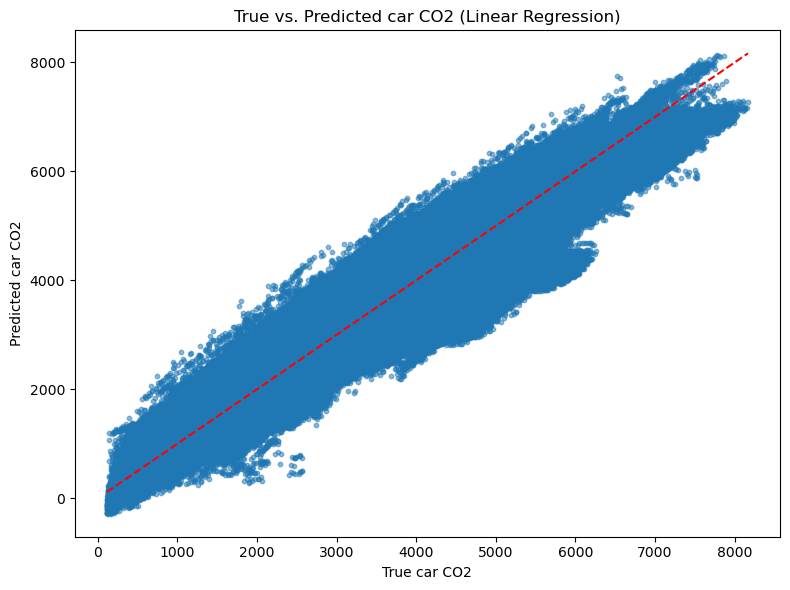

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

# 1. split by municipality

test_df = df[df['origin_municipality'].str.lower() == 'helsinki'].reset_index(drop=True)
train_df = df[df['origin_municipality'].str.lower() == 'espoo'].reset_index(drop=True)

# 2. Take 20% random sample of each (set random_state for reproducibility)
test_sample = test_df.sample(frac=0.5, random_state=42).copy()
train_sample = train_df.sample(frac=0.5, random_state=42).copy()

# 3. Columns to use
cat_features = ['Origin_Hexagon_ID', 'Destination_Hexagon_ID']
numerical_features = ['avg_speed', 'n_traffic_signals', 'stop_count','shortest_distance_m','car_time','population','total_built_area']
# numerical_features = ['avg_speed', 'n_traffic_signals', 'stop_count','shortest_distance_m','population','total_built_area']
# numerical_features = ['population', 'avg_speed', 'total_built_area', 'n_traffic_signals', 'stop_count', 'car_time']
# numerical_features = ['population', 'avg_speed', 'total_built_area', 'n_traffic_signals', 'stop_count']
target = 'car_co2'
all_features = cat_features + numerical_features + [target]

# 4. Drop rows with NaN in any relevant feature or target
train_sample = train_sample.dropna(subset=all_features)
test_sample = test_sample.dropna(subset=all_features)

# 5. Encode hex IDs as integers
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_sample[cat_features] = enc.fit_transform(train_sample[cat_features])
test_sample[cat_features]  = enc.transform(test_sample[cat_features])

# 6. Prepare data for ML
X_train = train_sample[cat_features + numerical_features].values
y_train = train_sample[target].values

X_test = test_sample[cat_features + numerical_features].values
y_test = test_sample[target].values

# 7. Fit model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8. Metrics and outputs
print("Test set size:", len(y_test))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# 9. Save predictions and true values
output_df = pd.DataFrame({
    "true_car_co2": y_test,
    "predicted_car_co2": y_pred
})
output_df.to_csv("car_co2_predictions_by_municipality.csv", index=False)
print("Predictions saved as car_co2_predictions_by_municipality.csv")

# 10. Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, s=10, alpha=0.5)
plt.xlabel("True car CO2")
plt.ylabel("Predicted car CO2")
plt.title("True vs. Predicted car CO2 (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


Feature importances (numerical features only):
avg_speed             :  1.22
n_traffic_signals     :  0.455
stop_count            :  4.43
shortest_distance_m   :  0.142
car_time              :  21.7
population            : -0.0113
total_built_area      : -0.00169


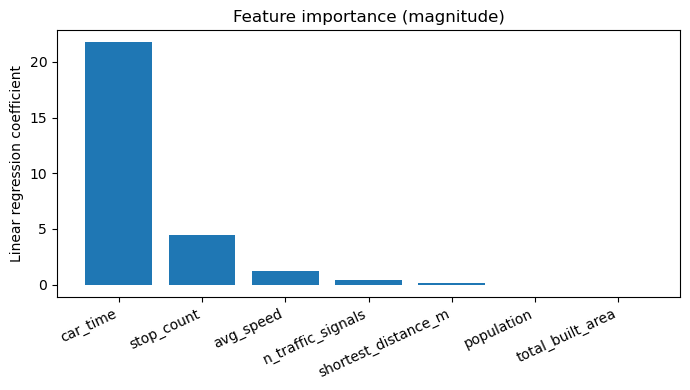

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get all feature names (categorical + numerical)
all_feature_names = cat_features + numerical_features

# 2. Get coefficients
coefs = model.coef_

# 3. Print coefficients for numerical features only (skip hexagon IDs)
num_idx = [all_feature_names.index(f) for f in numerical_features]
num_coefs = coefs[num_idx]

print("Feature importances (numerical features only):")
for name, coef in zip(numerical_features, num_coefs):
    print(f"{name:22s}: {coef: .3g}")

# 4. Plot
plt.figure(figsize=(7,4))
sorted_idx = np.argsort(np.abs(num_coefs))[::-1]
plt.bar([numerical_features[i] for i in sorted_idx], num_coefs[sorted_idx])
plt.xticks(rotation=25, ha='right')
plt.ylabel('Linear regression coefficient')
plt.title('Feature importance (magnitude)')
plt.tight_layout()
plt.show()


Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_linear.csv


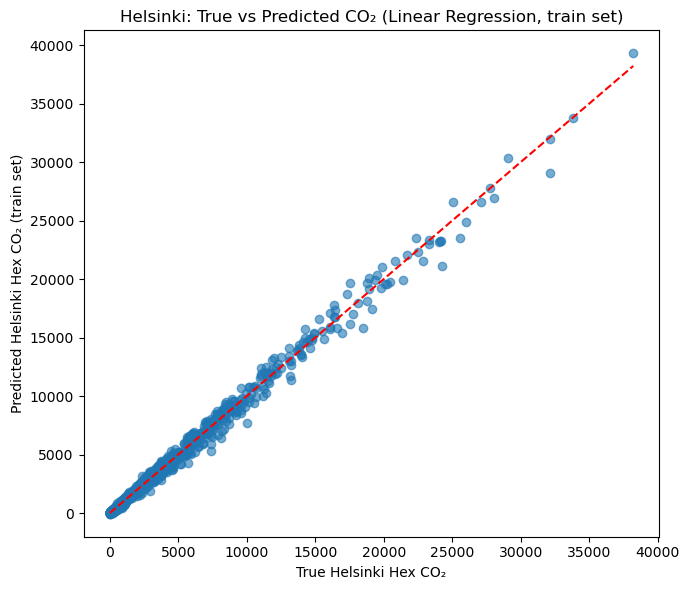


Test set size: 1208
MSE: 170880.53688959352
R^2: 0.9909660078544101


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load data
df_trip = pd.read_csv("locomizer_data_complete.csv")
df_hex = pd.read_csv("hex_attributes_combined.csv")
df_trip['one'] = 1

# 2. Aggregate per origin hexagon
agg_funcs = {
    'car_co2_locomizer': 'sum',
    'car_dist': 'sum',
    'car_time': 'sum',
    'shortest_distance_m': 'sum',
    'one': 'sum'
}
grouped = (
    df_trip
    .groupby('ORIGIN_CODE9')
    .agg(agg_funcs)
    .rename(columns={
        'car_co2_locomizer': 'total_car_co2',
        'car_dist': 'total_car_dist',
        'car_time': 'total_car_time',
        'shortest_distance_m': 'total_shortest_dist',
        'one': 'no_of_trips'
    })
    .reset_index()
    .rename(columns={'ORIGIN_CODE9': 'hex_id'})
)

# 3. Merge static attributes from df_hex
merged = grouped.merge(df_hex, on='hex_id', how='left')

# 4. Attach municipality info
if 'ORIGIN_Municipality' in df_trip.columns:
    muni = df_trip[['ORIGIN_CODE9', 'ORIGIN_Municipality']].drop_duplicates().rename(
        columns={'ORIGIN_CODE9': 'hex_id'}
    )
    merged = merged.merge(muni, on='hex_id', how='left')

# 5. Split by municipality
train = merged[merged['ORIGIN_Municipality'].str.lower() == 'espoo'].copy()
test = merged[merged['ORIGIN_Municipality'].str.lower() == 'helsinki'].copy()

# 6. Features for ML
features = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_car_dist', 'total_car_time', 'total_shortest_dist', 'no_of_trips'
]
target = 'total_car_co2'

train = train.dropna(subset=features + [target])
test = test.dropna(subset=features)

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# 7. Train and predict with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test['predicted_car_co2'] = y_pred

# 8. Save results
test[['hex_id', 'predicted_car_co2'] + features].to_csv('helsinki_hex_predicted_car_co2_linear.csv', index=False)
print("Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_linear.csv")

# 9. Plot true vs predicted for Espoo (train set)
y_train_pred = model.predict(X_train)
plt.figure(figsize=(7,6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("True Helsinki Hex CO₂")
plt.ylabel("Predicted Helsinki Hex CO₂ (train set)")
plt.title("Helsinki: True vs Predicted CO₂ (Linear Regression, train set)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()

# 10. Print test set metrics
print(f"\nTest set size: {len(y_pred)}")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))



Linear Regression model permutation importances:
total_car_dist      : 2.472
no_of_trips         : 0.143
total_shortest_dist : 0.006
total_car_time      : 0.006
population          : 0.000
total_built_area    : 0.000
n_traffic_signals   : 0.000
stop_count          : 0.000
avg_speed           : -0.000


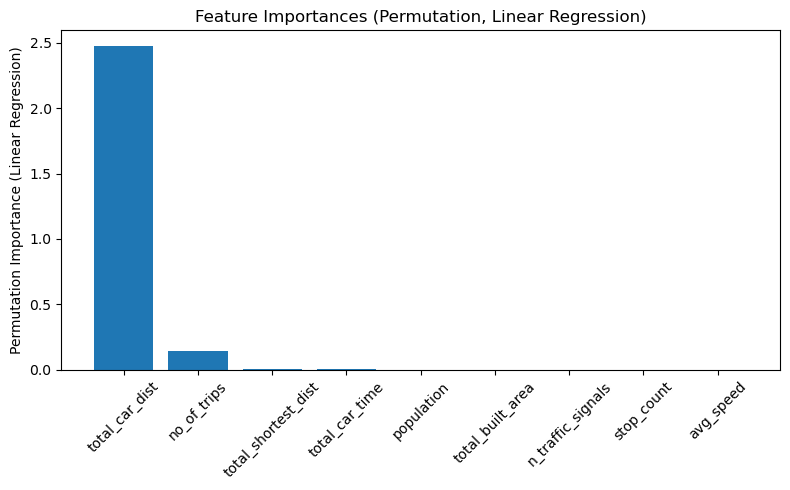

In [14]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming `model` is your trained LinearRegression model
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
sorted_idx = np.argsort(importances)[::-1]

print("\nLinear Regression model permutation importances:")
for idx in sorted_idx:
    print(f"{features[idx]:20s}: {importances[idx]:.3f}")

plt.figure(figsize=(8,5))
plt.bar([features[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=45)
plt.ylabel("Permutation Importance (Linear Regression)")
plt.title("Feature Importances (Permutation, Linear Regression)")
plt.tight_layout()
plt.show()
